This notebook demonstrates a predictive model for total time, based on network parameters (throughput measure, # of of files queued according to activity, and # of files completed over the previous hour) and per-file parameters (filesize, file activity type, 

In [79]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
matplotlib.rc('font', **{'size': 15})


src = 'AGLT2'
src = 'CERN-PROD'
dst = 'BNL-ATLAS'


#Create instance of ElasticSearch using the Atlas host server
es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)

In [80]:
query1 = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [81]:
import ast
import time

#Initialize convenient time intervals in milliseconds
currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliThreeWeek = 3*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHalfDay = 12*60*60*1000

milliHour = 60*60*1000

In [82]:
#Get files day interval (stagger a little from current time to get more interesting data)
start = currentMilliTime - milliThreeWeek
end = currentMilliTime

#Initialize lists
fileSize = []
activity = []
startedAt = []
submittedAt = []
transferredAt = []
duration = []
fileTimestamp = []

startPart = start
endPart = start
hourSeg = 24*7*2

weekTimestamp = []
weekFileSize = []
weekActivity = []
weekStartedAt = []
weekSubmittedAt = []
weekTransferredAt = []

#Step through day, getting all data in range
for i in range(hourSeg):
    endPart += milliHour
    response = es1.search(index="rucio-events*", body=ast.literal_eval(query1%(startPart,endPart)), request_timeout=600)
    startPart = endPart + 1
    
    #Get important fields
    for r in response['hits']['hits']:
        fileTimestamp.append(r['fields']['@timestamp'])
        fileSize.append(r['_source']['payload']['file-size'])
        activity.append(r['_source']['payload']['activity'])
        startedAt.append(r['_source']['payload']['started_at'])
        submittedAt.append(r['_source']['payload']['submitted_at'])
        transferredAt.append(r['_source']['payload']['transferred_at'])
    
    
    #Get random indices in range of length of data vectors
    ind = np.random.choice(len(fileSize),size=100,replace=False)
    np.random.seed()
    
    #Use this to obtain random sample of data, and save these to disk
    weekTimestamp += [ fileTimestamp[i] for i in ind]
    weekFileSize += [ fileSize[i] for i in ind]
    weekActivity += [ activity[i] for i in ind]
    weekStartedAt += [ startedAt[i] for i in ind]
    weekSubmittedAt += [ submittedAt[i] for i in ind]
    weekTransferredAt += [ transferredAt[i] for i in ind]

    if i%24 == 0:
        print('Hey!')

    
#fileSize = np.array(fileSize)
#activity = np.array(activity)
#startedAt = np.array(startedAt)
#submittedAt = np.array(submittedAt)
#transferredAt = np.array(transferredAt)

Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!


In [83]:

def get_ddm_data(es,src,dst,start,end,agg,field,timestamp=False):
    queryTemp = '''{
      "size": 0,
      "query": {
        "filtered": {
          "query": {
            "query_string": {
              "query": "src:%s AND dst:%s",
              "analyze_wildcard": True
            }
          },
          "filter": {
            "bool": {
              "must": [
                {
                  "range": {
                    "timestamp": {
                      "gte": %i,
                      "lte": %i,
                      "format": "epoch_millis"
                    }
                  }
                }
              ],
              "must_not": []
            }
          }
        }
      },
      "aggs": {
        "2": {
          "date_histogram": {
            "field": "timestamp",
            "interval": "1h",
            "time_zone": "Europe/Berlin",
            "min_doc_count": 1,
            "extended_bounds": {
              "min": %i,
              "max": %i
            }
          },
          "aggs": {
            "1": {
              "%s": {
                "field": "%s"
              }
            }
          }
        }
      }
    }'''

    query = ast.literal_eval(queryTemp%(src,dst,start,end,start,end,agg,field))
    response = es.search(index="atlas_ddm-metrics*", body=query, request_timeout=600)
    
    data = []
    if timestamp == False:
        for r in response['aggregations']['2']['buckets']:
            data.append(r['1']['value'])
        return np.array(data,dtype=np.float)
    
    elif timestamp == True:
        timestamp = []
        for r in response['aggregations']['2']['buckets']:
            data.append(r['1']['value'])
            timestamp.append(r['key'])
        return np.array(data,dtype=np.float),np.array(timestamp,dtype=np.float)

In [130]:
import time

tic = time.time()
#start and end left over from previous definition
#Get fields from another host

es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

agg = 'avg'

#Get current queued data according to activity
queuedTotal,timestamp = get_ddm_data(es2,src,dst,start,end,agg,'queued-total',timestamp=True)
queuedUserSubscriptions = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-User_Subscriptions')
queuedT0Export = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-T0_Export')
queuedStaging = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-Staging')
queuedDataConsolidation = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-Data_Consolidation')
queuedFunctionalTest = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-Functional_Test')
queuedExpress = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-Express')
queuedProductionInput = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-Production_Input')
queuedProductionOutput = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-Production_Output')
queuedStaging= get_ddm_data(es2,src,dst,start,end,agg,
                                                 'queued-Staging')

#Get done data history according to activity
doneUserSubscriptions = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-User_Subscriptions-1h')
doneT0Export = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-T0_Export-1h')
doneStaging = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-Staging-1h')
doneDataConsolidation = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-Data_Consolidation-1h')
doneFunctionalTest = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-Functional_Test-1h')
doneExpress = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-Express-1h')
doneProductionInput = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-Production_Input-1h')
doneProductionOutput = get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-Production_Output-1h')
doneStaging= get_ddm_data(es2,src,dst,start,end,agg,
                                                 'done-Staging-1h')

#Get other parameters
packetloss = get_ddm_data(es2,src,dst,start,end,agg,'packetloss')
dashThroughput1h = get_ddm_data(es2,src,dst,start,end,agg,'mbps-dashb-1h')
dashThroughput1d = get_ddm_data(es2,src,dst,start,end,agg,'mbps-dashb-1d')
ftsThroughput1h = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fts-1h')
ftsThroughput1d = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fts-1d')
faxThroughput1h = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fax-1h')
faxThroughput1d = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fax-1d')
doneTotal1h = get_ddm_data(es2,src,dst,start,end,agg,'done-total-1h')


print('Finished aggregating in %f seconds'%(time.time()-tic))

Finished aggregating in 157.025570 seconds


In [131]:
import datetime
from datetime import datetime

#Some useful functions for date conversion

def convertDateToDatetime(dates):
    '''
    Converts string dates to datetime objects
    '''
    datetimeDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        datetimeDates.append(epoch)
    return datetimeDates

def convertDateToMilliEpoch(dates):
    '''
    Converts string dates to milliEpoch values.
    '''
    epochDates = []
    zeroEpoch = datetime.utcfromtimestamp(0)    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
            
        epochDates.append((epoch - zeroEpoch).total_seconds() * 1000.0)
    return epochDates
        
        
    return datetimeDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

In [132]:
#Convert string timestamps to usable quantities (each per-file, BTW)

timeInQueue = getSecondsDifference(convertDateToDatetime(weekSubmittedAt),
                                   convertDateToDatetime(weekStartedAt))
timeTotal = getSecondsDifference(convertDateToDatetime(weekSubmittedAt),
                                 convertDateToDatetime(weekTransferredAt))
timeInTransfer = getSecondsDifference(convertDateToDatetime(weekStartedAt),
                                      convertDateToDatetime(weekTransferredAt))

timeInTransfer = np.array(timeInTransfer)
timeTotal = np.array(timeTotal)
timeInQueue = np.array(timeInQueue)

In [133]:
#Get times that each file is submitted at

submittedTimes = np.array(convertDateToMilliEpoch(weekSubmittedAt))

#Get indices for sorting (use these indices to sort any ddm-metrics variables)
timeIndex = np.argsort(submittedTimes)
submittedTimes = submittedTimes[timeIndex]

#Sort according to monotonically increasing file-submitted timestamp
filesize = np.array(weekFileSize)[timeIndex]
activity = {'activity':np.array(weekActivity)[timeIndex]}
timeTotal = timeTotal[timeIndex]

In order to regress categorical data, I represented n choices for a categorical variable as an n-vector, where each index of the vector stood for a different category. The index for the appropriate category holds a value of 1, and the rest of the indices are zero.

In [134]:
import pandas as pd
#Convert to panda dataframe, convert from categorical to numerical
df = pd.DataFrame(activity)
dummyActivity = np.array(pd.get_dummies(df['activity']))

In [135]:
#Get indices that relate the two timescales between metrics
binIndex = np.digitize(submittedTimes,timestamp)-1

#Make the bin sort
#Convert NaNs to zeros for all the queued datasets
queuedTotal = np.nan_to_num(queuedTotal)[binIndex]
queuedUserSubscriptions = np.nan_to_num(queuedUserSubscriptions)[binIndex]
queuedT0Export = np.nan_to_num(queuedT0Export)[binIndex]
queuedStaging = np.nan_to_num(queuedStaging)[binIndex]
queuedDataConsolidation = np.nan_to_num(queuedDataConsolidation)[binIndex]
queuedFunctionalTest = np.nan_to_num(queuedFunctionalTest)[binIndex]
queuedExpress = np.nan_to_num(queuedExpress)[binIndex]
queuedProductionInput = np.nan_to_num(queuedProductionInput)[binIndex]
queuedProductionOutput = np.nan_to_num(queuedProductionOutput)[binIndex]
queuedStaging = np.nan_to_num(queuedStaging)[binIndex]

#Convert NaNs to zeros for all the done datasets
doneUserSubscriptions = np.nan_to_num(doneUserSubscriptions)[binIndex]
doneT0Export = np.nan_to_num(doneT0Export)[binIndex]
doneStaging = np.nan_to_num(doneStaging)[binIndex]
doneDataConsolidation = np.nan_to_num(doneDataConsolidation)[binIndex]
doneFunctionalTest = np.nan_to_num(doneFunctionalTest)[binIndex]
doneExpress = np.nan_to_num(doneExpress)[binIndex]
doneProductionInput = np.nan_to_num(doneProductionInput)[binIndex]
doneProductionOutput = np.nan_to_num(doneProductionOutput)[binIndex]
doneStaging = np.nan_to_num(doneStaging)[binIndex]

loss = packetloss[binIndex]
times = timestamp[binIndex]
dash_through1h = dashThroughput1h[binIndex]
dash_through1d = dashThroughput1d[binIndex]
fts_through1d = ftsThroughput1d[binIndex]
fts_through1h = ftsThroughput1h[binIndex]
done_total1h = doneTotal1h[binIndex]


In [136]:
#Form input by combining various variables
inputSample = np.squeeze(np.hstack((submittedTimes[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],
                                    doneUserSubscriptions[:,None],
                                    doneT0Export[:,None],doneStaging[:,None],
                                    doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    doneExpress[:,None],doneProductionInput[:,None],
                                    doneProductionOutput[:,None],doneStaging[:,None],filesize[:,None],
                                    dash_through1h[:,None],dummyActivity)))
outputSample = timeTotal

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing]
reducedOutput = outputSample[~missing]


In [137]:
import pandas
from sklearn import cross_validation

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = reducedInput
Y = reducedOutput

tic = time.time()
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
    X, Y,test_size=0.4, random_state=2)

poly = PolynomialFeatures(degree=2)
Xtrain_ = poly.fit_transform(X_train[:,1:])
Xtest_ = poly.fit_transform(X_test[:,1:])


clf = LinearRegression()
clf.fit(Xtrain_,Y_train)

Y_predict = clf.predict(Xtest_)
toc = time.time()

print("This took %f seconds"%(toc-tic))

This took 0.815599 seconds


4847.98318498


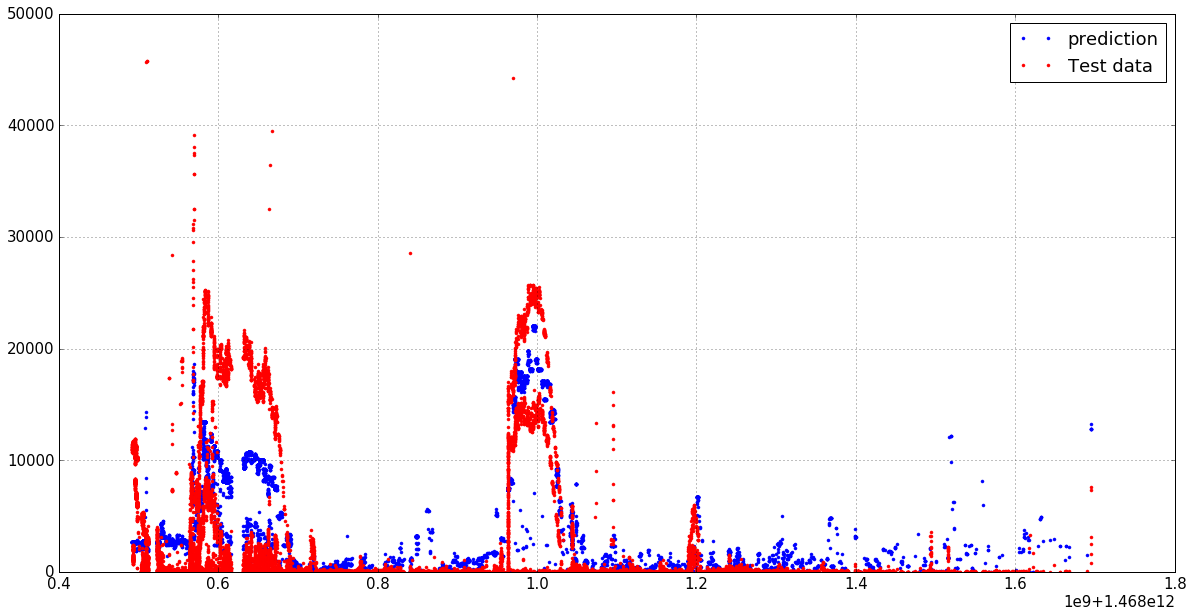

In [138]:
Y_predict[Y_predict < 0] = 0

rmse = np.sqrt(((Y_predict - Y_test) ** 2).mean())
nrmse = rmse/(Y_test.max()-Y_test.min())
print(rmse)

plt.figure(figsize=(20,10))
plt.plot(X_test[:,0],Y_predict,'b.',label='prediction')
plt.plot(X_test[:,0],Y_test,'r.',label='Test data')
plt.legend()
plt.grid()

In [159]:
import pandas
from sklearn.linear_model import LinearRegression

X = reducedInput
Y = reducedOutput

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
    X, Y,test_size=0.7, random_state=1)

model = LinearRegression()
Y_predict = model.fit(X_train[:,1:],Y_train).predict(X_test[:,1:])

5281.72680761


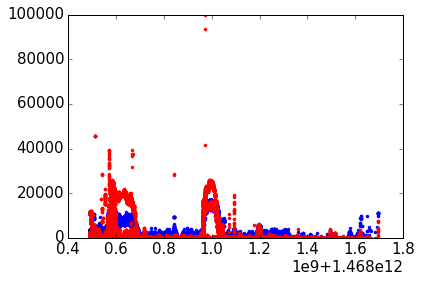

In [161]:
Y_predict[Y_predict < 0] = 0

rmse = np.sqrt(((Y_predict - Y_test) ** 2).mean())
nrmse = rmse/(Y_test.max()-Y_test.min())
print(rmse)
plt.plot(X_test[:,0],Y_predict,'b.')
plt.plot(X_test[:,0],Y_test,'r.')

Correctly classified time ratio is 0.965839416058


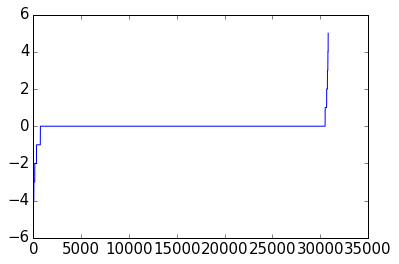

In [311]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,
                              AdaBoostClassifier,ExtraTreesClassifier)
def convertSecsToCat(data):
    timeCategory = np.zeros(len(data))
    for i in range(len(data)):
        if data[i] < 600: #Less than 10 min
            timeCategory[i] = 0
        elif data[i] >= 600 and data[i] < 1200:#(10-20 min)
            timeCategory[i] = 1
        elif (data[i] >= 1200 and data[i] < 3600): #(between 20 min and 1 hour)
            timeCategory[i] = 2
        elif data[i] >=3600 and data[i] < 7200: #(between 1 and 2 hr)
            timeCategory[i] = 3
        elif data[i] >= 7200 and data[i] < 18000: #(2-5 hour)
            timeCategory[i] = 4
        elif data[i] >= 18000 and data[i] < 36000: #(5-10 hours)
            timeCategory[i] = 5
        elif data[i] >= 36000:
            timeCategory[i] = 6
    return timeCategory
timeCategory = convertSecsToCat(Y)


#Form input by combining various variables
inputSample = np.squeeze(np.hstack((submittedTimes[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],
                                    doneUserSubscriptions[:,None],
                                    doneT0Export[:,None],doneStaging[:,None],
                                    doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    doneExpress[:,None],doneProductionInput[:,None],
                                    doneProductionOutput[:,None],doneStaging[:,None],filesize[:,None],
                                    dash_through1h[:,None],dummyActivity)))
outputSample = timeTotal

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing]
reducedOutput = outputSample[~missing]


X = reducedInput
Y = reducedOutput

model1 = RandomForestClassifier()

results = model1.fit(X[:,1:],timeCategory)
Y_predict = results.predict(X[:,1:])
Y_proba = results.predict_proba(X[:,1:])


diff = (Y_predict-timeCategory)
indices4 = np.argsort(diff)

print('Correctly classified time ratio is ' + str(np.sum(diff==0)/len(diff)))
#Note the probabilities of the end objects are usually split between several categories
plt.plot(diff[indices4])

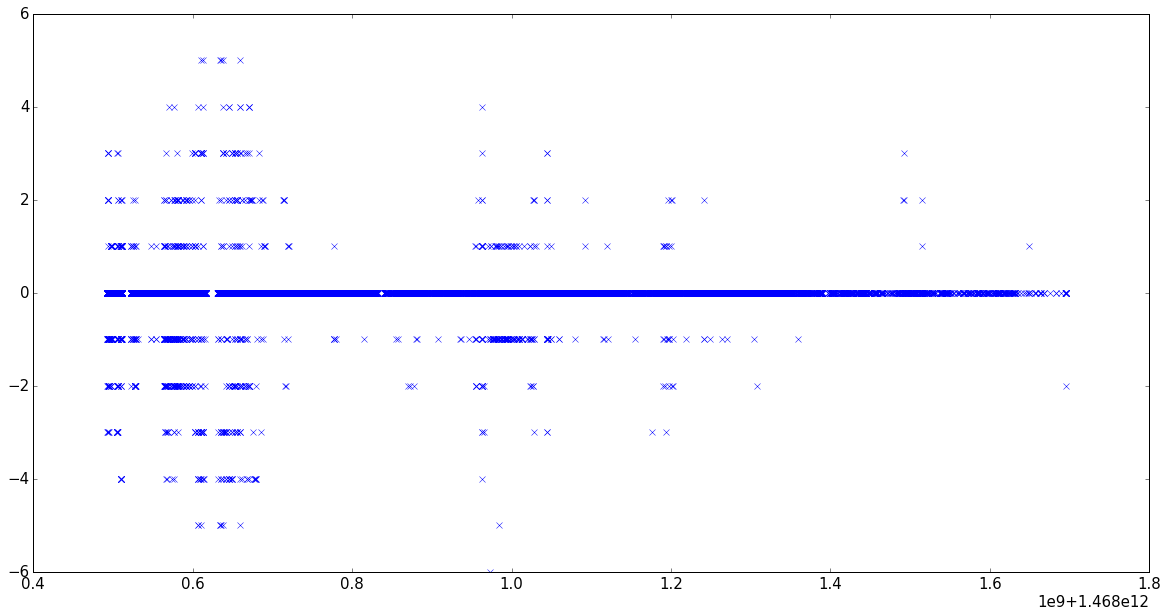

In [276]:
plt.figure(figsize=(20,10))
plt.plot(X[:,0],Y_predict-timeCategory,'bx')


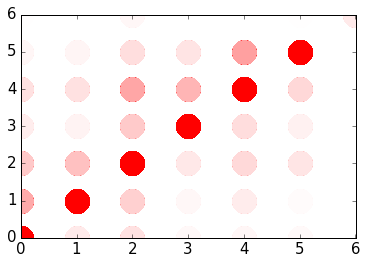

In [297]:
plt.plot(Y_predict,timeCategory,'r.',markersize=50,alpha=0.005)